In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl
import seaborn as sns
import re
from math import atan2,degrees
from scipy.interpolate import make_interp_spline, BSpline


cmap1 = mpl.colormaps['viridis'].resampled(8)
cmap2 = mpl.colormaps['inferno'].resampled(8)

In [3]:
# Label line with line2D label data
def labelLine(line, x, label=None, align=True, **kwargs):
    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)

def _assign_labels(data, labels):
    assert len(data) == len(labels)
    for frameidx, frame in enumerate(data):
        data[frameidx] = frame.assign(id=labels[frameidx])

def plot_metric(data, xcol, ycol, idlabels=None, xlabel=None, ylabel=None, hue="id", log=True, estimator=np.median, errorbar=("pi", 50)):
    if idlabels:
        _assign_labels(data, idlabels)

    sns.set_context("paper")
    sns.set_theme(style="ticks")
    sns.despine()

    if not isinstance(data, pd.DataFrame):
        data = pd.concat(data)

    ax = sns.catplot(data=data, x=xcol, y=ycol, hue=hue, estimator=estimator, kind="point", errorbar=errorbar)
    ax._legend.remove()

    ax.set(xticks=range(len(data[xcol].unique())))
    if log:
        ax.set(yscale="log")
    if xlabel:
       ax.set(xlabel=xlabel)
    if ylabel:
       ax.set(ylabel=ylabel)

    plt.show()

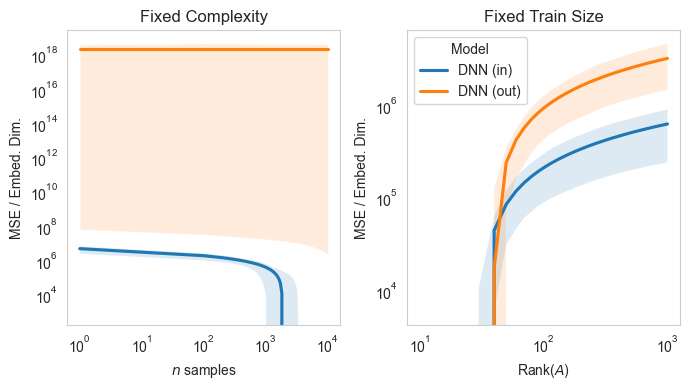

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(7, 4))
df1 = pd.read_csv("../cache/LDS/simple_data_6_True.csv")
df1["id"] = "DNN (in)"
df2 = pd.read_csv("../cache/LDS/simple_data_6_False.csv")
df2["id"] = "DNN (out)"
_ = sns.regplot(
    ax=axs[0],
    data=df1,
    x="n", y="loss",
    label="DNN (in)",
    ci=50,
    # robust=True,
    logx=True,
    # fit_reg=True
    # lowess=True,
    # order=2,
    scatter=False,
)
_ = sns.regplot(
    ax=axs[0],
    data=df2,
    x="n", y="loss",
    label="DNN (out)",
    ci=50,
    scatter=False,
    # robust=True,
    # fit_reg=True
    logx=True
)

axs[0].grid(visible=False)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_xlabel(r"$n$ samples")
axs[0].set_ylabel("MSE / Embed. Dim.")
# axs[0].legend(title="Model")
axs[0].set_title("Fixed Complexity")

df1 = pd.read_csv("../cache/LDS/simple/fts_n=100_in_dist=True.csv")
df1["id"] = "DNN (in)"
df2 = pd.read_csv("../cache/LDS/simple/fts_n=100_in_dist=False.csv")
df2["id"] = "DNN (out)"
_ = sns.regplot(
    ax=axs[1],
    data=df1,
    x="latent_dim", y="loss",
    label="DNN (in)",
    ci=50,
    scatter=False,
    # robust=True,
    # fit_reg=True
    logx=True
    # order=2
)
_ = sns.regplot(
    ax=axs[1],
    data=df2,
    x="latent_dim", y="loss",
    label="DNN (out)",
    ci=50,
    # robust=True,
    scatter=False,
    # fit_reg=True
    logx=True
    # order=2
)

axs[1].grid(visible=False)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_xlabel(r"Rank($A$)")
axs[1].set_ylabel("MSE / Embed. Dim.")
axs[1].legend(title="Model")
axs[1].set_title("Fixed Train Size")

plt.tight_layout()
plt.show()

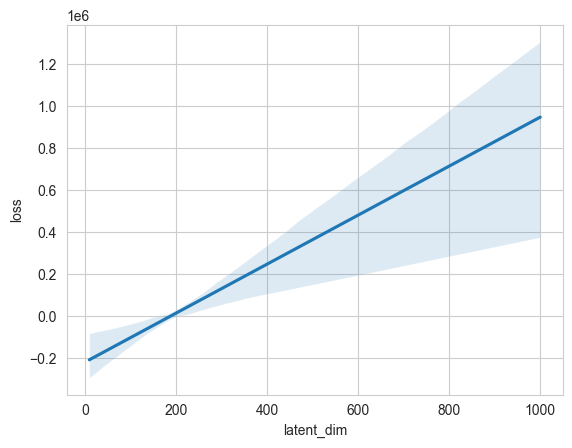

In [9]:
df1 = pd.read_csv("../cache/LDS/simple/fts_n=100_in_dist=True.csv")
df1["id"] = "DNN (in)"
df2 = pd.read_csv("../cache/LDS/simple/fts_n=100_in_dist=False.csv")
df2["id"] = "DNN (out)"
_ = sns.regplot(
    ax=axs[1],
    data=df1,
    x="latent_dim", y="loss",
    label="DNN (in)",
    ci=50,
    # robust=True,
    # facet_kws=dict(sharey=False),
    scatter=False,
    fit_reg=True
)
_ = sns.regplot(
    ax=axs[1],
    data=df2,
    x="latent_dim", y="loss",
    label="DNN (out)",
    ci=50,
    # robust=True,
    # facet_kws=dict(sharey=False),
    scatter=False,
    fit_reg=True
